# S4 WESAD XGBoost  

    Female Participant
    Age: 29
    Height (cm): 165
    Weight (kg): 55

# Load Tools

In [3]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score 
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.utils import class_weight
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier

In [5]:
# Visualizing High-Performance Gradient Boosting with XGBoost and Yellowbrick
# https://rebeccabilbro.github.io/xgboost-and-yellowbrick/
# conda install -c districtdatalabs yellowbrick

from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError

In [6]:
sns.set(style="darkgrid")

In [7]:
# https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed#:~:text=Colors%3A%20Use%20this%20code%3A%20%3C,space%2C%20then%20type%20the%20text.
# https://www.w3schools.com/charsets/ref_utf_geometric.asp# import pydot

In [8]:
import autoreload
%load_ext watermark
%load_ext autoreload
%autoreload 2
%watermark -a 'WForsythe' -d -t -v -p   numpy,pandas,cv2,xgboost,sklearn,seaborn,matplotlib,yellowbrick

WForsythe 2020-08-02 16:36:17 

CPython 3.7.6
IPython 7.11.1

numpy 1.18.1
pandas 1.0.3
cv2 4.2.0
xgboost 1.0.2
sklearn 0.22.1
seaborn 0.9.0
matplotlib 3.2.2
yellowbrick 1.1


# Load and Process File

## Load File

In [9]:
%%time
data = 'D:/WESAD/'
s17_file = pd.read_pickle(data + 'S17/S17.pkl')
s17_file

Wall time: 11.4 s


{'signal': {'chest': {'ACC': array([[ 0.70019996, -0.19819999, -1.07019997],
          [ 0.72940004, -0.19019997, -1.04700005],
          [ 0.76460004, -0.18400002, -1.00460005],
          ...,
          [ 0.90279996, -0.0424    , -0.1864    ],
          [ 0.90020001, -0.04079998, -0.18540001],
          [ 0.89960003, -0.04140002, -0.18620002]]),
   'ECG': array([[1.43179321],
          [1.46195984],
          [1.47161865],
          ...,
          [0.16712952],
          [0.17033386],
          [0.17523193]]),
   'EMG': array([[ 0.00709534],
          [-0.0124054 ],
          [-0.01808167],
          ...,
          [-0.0160675 ],
          [ 0.00517273],
          [ 0.02275085]]),
   'EDA': array([[5.40046692],
          [5.40885925],
          [5.40161133],
          ...,
          [7.26280212],
          [7.26966858],
          [7.2681427 ]]),
   'Temp': array([[32.415283],
          [32.43463 ],
          [32.4451  ],
          ...,
          [33.86429 ],
          [33.862762],
   

## Process

### Separate chest features  from wrist  features 

In [10]:
cax = s17_file['signal']['chest']['ACC'][0:,0]
cay = s17_file['signal']['chest']['ACC'][0:,1]
caz = s17_file['signal']['chest']['ACC'][0:,2]
cecg = s17_file['signal']['chest']['ECG'][:,0]
cemg = s17_file['signal']['chest']['EMG'][:,0]
ceda = s17_file['signal']['chest']['EDA'][:,0]
ctemp = s17_file['signal']['chest']['Temp'][:,0]
cresp = s17_file['signal']['chest']['Resp'][:,0]
label = s17_file['label']

In [11]:
label

array([0, 0, 0, ..., 0, 0, 0])

### Change dictionary object to a numpy array and array to a dataframe

In [12]:
# Python | Numpy ndarray.T
# https://www.geeksforgeeks.org/python-numpy-ndarray-t/
# Numpy Array Cookbook: Generating and Manipulating Arrays in Python
# https://towardsdatascience.com/numpy-array-cookbook-generating-and-manipulating-arrays-in-python-2195c3988b09

In [13]:
chest = [cax, cay, caz, cecg, cemg, 
         ceda, ctemp, cresp, label] 
ch_array = np.array(chest) 
ch_array = ch_array.T # transpose 
Columns = ['cax', 'cay', 'caz','cecg', 'cemg', 
          'ceda','ctemp', 'cresp', 'label' ]
ch_df = pd.DataFrame(ch_array, columns = Columns) 
ch_df

,cax,cay,caz,cecg,cemg,ceda,ctemp,cresp,label
0,0.7002,-0.1982,-1.0702,1.431793,0.007095,5.400467,32.415283,3.221130,0.0
1,0.7294,-0.1902,-1.0470,1.461960,-0.012405,5.408859,32.434631,3.607178,0.0
2,0.7646,-0.1840,-1.0046,1.471619,-0.018082,5.401611,32.445099,3.608704,0.0
3,0.8014,-0.1778,-0.9782,1.472763,-0.027557,5.407715,32.439087,3.643799,0.0
4,0.8348,-0.1608,-0.8950,1.469421,-0.026779,5.410385,32.439087,3.575134,0.0
...,...,...,...,...,...,...,...,...,...
4143995,0.9006,-0.0400,-0.1898,0.173676,-0.005539,7.265091,33.862762,0.318909,0.0
4143996,0.9022,-0.0398,-0.1872,0.168777,-0.004944,7.266617,33.859741,0.233459,0.0
4143997,0.9028,-0.0424,-0.1864,0.167130,-0.016068,7.262802,33.864288,0.318909,0.0
4143998,0.9002,-0.0408,-0.1854,0.170334,0.005173,7.269669,33.862762,0.308228,0.0


#### Check Statistics

In [14]:
ch_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cax,4144000.0,0.632924,0.232578,0.181000,0.386600,0.647000,0.877800,1.859400
cay,4144000.0,-0.015859,0.060026,-0.665600,-0.059800,-0.001800,0.027000,0.541600
caz,4144000.0,-0.581079,0.315453,-1.321400,-0.885400,-0.683000,-0.275400,1.474400
cecg,4144000.0,0.000965,0.286104,-1.258484,-0.110916,-0.039963,0.017899,1.499954
cemg,4144000.0,-0.004101,0.017794,-0.901337,-0.011765,-0.003891,0.003525,1.138412
ceda,4144000.0,6.491610,0.810352,5.057526,5.738068,6.290817,7.224655,8.211136
ctemp,4144000.0,33.774129,0.423570,32.102783,33.529327,33.674652,34.106201,34.755402
cresp,4144000.0,0.047059,4.809081,-28.024292,-2.397156,-0.256348,2.641296,28.684998
label,4144000.0,1.302363,1.615107,0.000000,0.000000,1.000000,2.000000,7.000000


#### Check Type

In [15]:
print(ch_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4144000 entries, 0 to 4143999
Data columns (total 9 columns):
 #   Column  Dtype  
---  ------  -----  
 0   cax     float64
 1   cay     float64
 2   caz     float64
 3   cecg    float64
 4   cemg    float64
 5   ceda    float64
 6   ctemp   float64
 7   cresp   float64
 8   label   float64
dtypes: float64(9)
memory usage: 284.5 MB
None


### Concatenate classes 0, 1, 2, 3, and 4
    Classes 5, 6 and 7 correspond to timed periods in which the participant answered questionnaires, 
    therefore, only classes 0, 1, 2, 3, and 4 will be used 
    Additionally, the significant imbalance has been eliminated

In [16]:
loc0 = ch_df.loc[ch_df['label'] == 0]
loc1 = ch_df.loc[ch_df['label'] == 1]
loc2 = ch_df.loc[ch_df['label'] == 2]
loc3 = ch_df.loc[ch_df['label'] == 3]
loc4 = ch_df.loc[ch_df['label'] == 4]

In [17]:
ch_loc = pd.concat([loc0, loc1, loc2, loc3, loc4])
ch_loc

,cax,cay,caz,cecg,cemg,ceda,ctemp,cresp,label
0,0.7002,-0.1982,-1.0702,1.431793,0.007095,5.400467,32.415283,3.221130,0.0
1,0.7294,-0.1902,-1.0470,1.461960,-0.012405,5.408859,32.434631,3.607178,0.0
2,0.7646,-0.1840,-1.0046,1.471619,-0.018082,5.401611,32.445099,3.608704,0.0
3,0.8014,-0.1778,-0.9782,1.472763,-0.027557,5.407715,32.439087,3.643799,0.0
4,0.8348,-0.1608,-0.8950,1.469421,-0.026779,5.410385,32.439087,3.575134,0.0
...,...,...,...,...,...,...,...,...,...
3957259,0.4826,-0.0094,-0.8248,0.195236,0.013962,7.021713,34.080353,14.350891,4.0
3957260,0.4838,-0.0088,-0.8298,0.178574,0.013504,7.020569,34.084900,14.419556,4.0
3957261,0.4872,-0.0086,-0.8294,0.158020,0.024353,7.020569,34.022461,14.363098,4.0
3957262,0.4858,-0.0080,-0.8376,0.129959,0.004623,7.029724,34.063538,14.361572,4.0


#### Check Statistics

In [18]:
ch_loc.describe().T

,count,mean,std,min,25%,50%,75%,max
cax,4022201.0,0.625521,0.232062,0.181000,0.385000,0.638400,0.875800,1.859400
cay,4022201.0,-0.016564,0.060754,-0.665600,-0.061000,-0.003800,0.028000,0.541600
caz,4022201.0,-0.590528,0.315183,-1.321400,-0.886200,-0.691400,-0.280600,1.474400
cecg,4022201.0,0.000970,0.286113,-1.258484,-0.111282,-0.040237,0.017990,1.499954
cemg,4022201.0,-0.004097,0.017965,-0.901337,-0.011765,-0.003891,0.003571,1.138412
ceda,4022201.0,6.492656,0.811025,5.057526,5.739975,6.296158,7.221985,8.211136
ctemp,4022201.0,33.775670,0.425098,32.102783,33.533875,33.677673,34.103210,34.755402
cresp,4022201.0,0.044936,4.788009,-28.024292,-2.362061,-0.218201,2.647400,28.684998
label,4022201.0,1.160285,1.407391,0.000000,0.000000,1.000000,2.000000,4.000000


#### Plot all classes vs. classes 0,1,2,3,4 

4144000 4022201
Number of Rows Removed: 121799


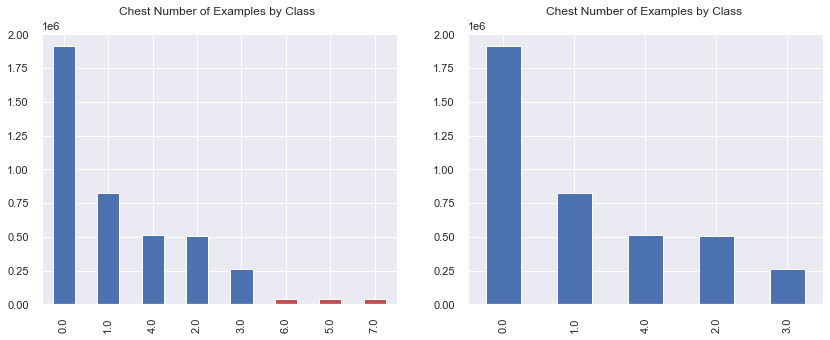

In [19]:
plt.figure(figsize = (14,5))
plt.subplot(1, 2, 1)
ch_df['label'].value_counts().plot(kind='bar', 
                                     title='Chest Number of Examples by Class \n',
                                     color=['b','b','b','b','b','r','r','r'])
plt.subplot(1, 2, 2)
ch_loc['label'].value_counts().plot(kind='bar', 
                                     title='Chest Number of Examples by Class \n')
print((ch_df['label'].value_counts().sum()), ch_loc['label'].value_counts().sum())
print('Number of Rows Removed:', (ch_df['label'].value_counts().sum()) - 
      ch_loc['label'].value_counts().sum());

**XGBoost for Multi-class Classification** <br>
https://towardsdatascience.com/xgboost-for-multi-class-classification-799d96bcd368

In [19]:
# Multiclass ROC AUC Score original script sourced from 
'''
Author: Plog, E
Title: AUC ROC Curve Scoring Function for Multi-class Classification
Date: 2018
Code version: n.a.
Availability: https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659
'''

'\nAuthor: Plog, E\nTitle: AUC ROC Curve Scoring Function for Multi-class Classification\nDate: 2018\nCode version: n.a.\nAvailability: https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659\n'

# Model Runs: XGBoost Classifier

## Model allChest: All chest features

### Train Test

In [20]:
y = ch_loc.label
x = ch_loc.drop('label',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)
print(y_test.shape)
evalSet = [(x_train, y_train), (x_test, y_test)]

(3217760, 8)
(804441,)


### Check Correlations

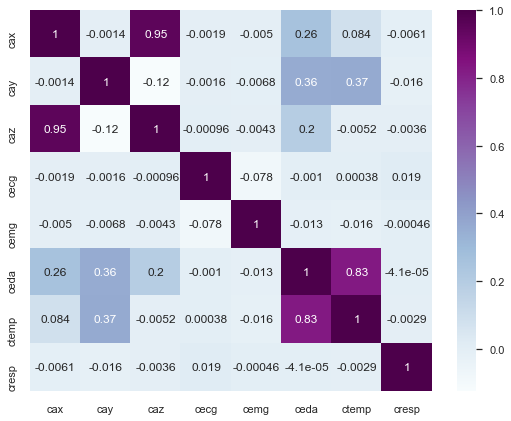

In [21]:
plt.figure(figsize=(9,7))
sns.heatmap(x_train.corr(), annot=True, cmap=plt.cm.BuPu);

    There is a very strong correlation between caz and cax 
    There is very strong relationship between eda and temp

### Model Fit and f1 and Balanced Accuracy Scores

In [22]:
%%time
allChest = xgb.XGBClassifier(objective = 'multi:softmax',
                              tree_method = 'gpu_hist',
                              learning_rate = 0.1,
                              n_estimators = 300, 
                              #max_depth = 10,
                              #deterministic_histogram = 'false',
                              gradient_based = 0.1,
                              num_early_stopping_rounds = 20,
                              gamma = 3,
                              #seed = 24,
                              verbosity = 2) 

model_allChest = allChest.fit(x_train,y_train, 
                              eval_metric=['merror'],
                              eval_set = evalSet) 
allChest_pred = allChest.predict(x_test)
allChest_report = (classification_report(y_test,
                                         allChest_pred,
                                         labels=np.unique(allChest_pred),
                                         digits=4))

print('Balanced Accuracy:', balanced_accuracy_score(y_test, allChest_pred))
print('----------------------------------------')
print('------------ S11 All Chest Classification Report------------')
print(allChest_report)

[0]	validation_0-merror:0.02911	validation_1-merror:0.02949
[1]	validation_0-merror:0.02916	validation_1-merror:0.02955
[2]	validation_0-merror:0.02881	validation_1-merror:0.02918
[3]	validation_0-merror:0.02822	validation_1-merror:0.02857
[4]	validation_0-merror:0.02821	validation_1-merror:0.02856
[5]	validation_0-merror:0.02855	validation_1-merror:0.02892
[6]	validation_0-merror:0.02841	validation_1-merror:0.02875
[7]	validation_0-merror:0.02755	validation_1-merror:0.02790
[8]	validation_0-merror:0.02729	validation_1-merror:0.02764
[9]	validation_0-merror:0.02729	validation_1-merror:0.02759
[10]	validation_0-merror:0.02723	validation_1-merror:0.02752
[11]	validation_0-merror:0.02653	validation_1-merror:0.02684
[12]	validation_0-merror:0.02600	validation_1-merror:0.02636
[13]	validation_0-merror:0.02517	validation_1-merror:0.02556
[14]	validation_0-merror:0.02512	validation_1-merror:0.02545
[15]	validation_0-merror:0.02495	validation_1-merror:0.02530
[16]	validation_0-merror:0.02415	v

[134]	validation_0-merror:0.00880	validation_1-merror:0.00920
[135]	validation_0-merror:0.00878	validation_1-merror:0.00916
[136]	validation_0-merror:0.00874	validation_1-merror:0.00913
[137]	validation_0-merror:0.00870	validation_1-merror:0.00909
[138]	validation_0-merror:0.00867	validation_1-merror:0.00908
[139]	validation_0-merror:0.00861	validation_1-merror:0.00903
[140]	validation_0-merror:0.00859	validation_1-merror:0.00902
[141]	validation_0-merror:0.00855	validation_1-merror:0.00896
[142]	validation_0-merror:0.00848	validation_1-merror:0.00889
[143]	validation_0-merror:0.00845	validation_1-merror:0.00887
[144]	validation_0-merror:0.00843	validation_1-merror:0.00886
[145]	validation_0-merror:0.00840	validation_1-merror:0.00881
[146]	validation_0-merror:0.00831	validation_1-merror:0.00872
[147]	validation_0-merror:0.00829	validation_1-merror:0.00869
[148]	validation_0-merror:0.00826	validation_1-merror:0.00869
[149]	validation_0-merror:0.00822	validation_1-merror:0.00863
[150]	va

[267]	validation_0-merror:0.00600	validation_1-merror:0.00649
[268]	validation_0-merror:0.00599	validation_1-merror:0.00648
[269]	validation_0-merror:0.00598	validation_1-merror:0.00647
[270]	validation_0-merror:0.00597	validation_1-merror:0.00645
[271]	validation_0-merror:0.00597	validation_1-merror:0.00644
[272]	validation_0-merror:0.00596	validation_1-merror:0.00644
[273]	validation_0-merror:0.00596	validation_1-merror:0.00643
[274]	validation_0-merror:0.00595	validation_1-merror:0.00644
[275]	validation_0-merror:0.00595	validation_1-merror:0.00644
[276]	validation_0-merror:0.00595	validation_1-merror:0.00644
[277]	validation_0-merror:0.00595	validation_1-merror:0.00644
[278]	validation_0-merror:0.00595	validation_1-merror:0.00644
[279]	validation_0-merror:0.00595	validation_1-merror:0.00644
[280]	validation_0-merror:0.00595	validation_1-merror:0.00644
[281]	validation_0-merror:0.00595	validation_1-merror:0.00644
[282]	validation_0-merror:0.00595	validation_1-merror:0.00644
[283]	va

### Confusion Matrix

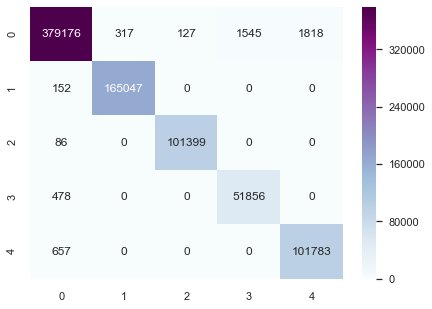

In [23]:
cm = confusion_matrix(y_test, allChest_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.BuPu );

### Multi-class AUC Score

In [24]:
def multiclass_roc_auc_score(y_test, allChest_pred, average = 'micro'): 
    xg = preprocessing.LabelBinarizer()
    xg.fit(y_test)
    y_test1 = xg.transform(y_test) 
    y_pred1 = xg.transform(allChest_pred)
    return roc_auc_score(y_test1, y_pred1, average=average)

aucScore = multiclass_roc_auc_score(y_test, allChest_pred)

print('S11 All Chest')
print('---------------------')
print("AUC: %.2f%%" % (aucScore*100))

S11 All Chest
---------------------
AUC: 99.60%


## Model ch_lessAcc: Chest Less Accelerometer  

### Train Test Split

In [25]:
lessAcc = ch_loc[['ceda', 'ctemp', 'cresp', 'cemg', 'cecg', 'label']]
y = lessAcc.label
x = lessAcc.drop('label',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)
print(y_test.shape)

(3217760, 5)
(804441,)


### Model Fit and f1 and Balanced Accuracy Scores

In [26]:
%%time
ch_lessAcc = XGBClassifier(objective = 'multi:softmax',
                              tree_method = 'gpu_hist',
                              learning_rate = 0.1,
                              n_estimators = 300, 
                              #max_depth = 10,
                              #deterministic_histogram = 'false',
                              gradient_based = 0.1,
                              num_early_stopping_rounds = 20,
                              gamma = 3,
                              #seed = 24,
                              verbosity = 2) 

model_ch_lessAcc = ch_lessAcc.fit(x_train,y_train)
ch_lessAcc_pred = ch_lessAcc.predict(x_test)
ch_lessAcc_report = (classification_report(y_test,
                                           ch_lessAcc_pred,
                                           labels=np.unique(ch_lessAcc_pred),
                                           digits=4))

print('Balanced Accuracy:', balanced_accuracy_score(y_test, ch_lessAcc_pred))
print('----------------------------------------')
print('------------ S11 All Chest less ACC Classification Report------------')
print(ch_lessAcc_report)

Balanced Accuracy: 0.9405464126744864
----------------------------------------
------------ S11 All Chest less ACC Classification Report------------
              precision    recall  f1-score   support

         0.0     0.9598    0.9577    0.9587    383721
         1.0     0.9952    0.9965    0.9959    165036
         2.0     0.9629    0.9391    0.9509    101118
         3.0     0.9092    0.8934    0.9012     52210
         4.0     0.8815    0.9160    0.8984    102356

    accuracy                         0.9539    804441
   macro avg     0.9417    0.9405    0.9410    804441
weighted avg     0.9542    0.9539    0.9540    804441

Wall time: 1min 26s


### Confusion Matrix

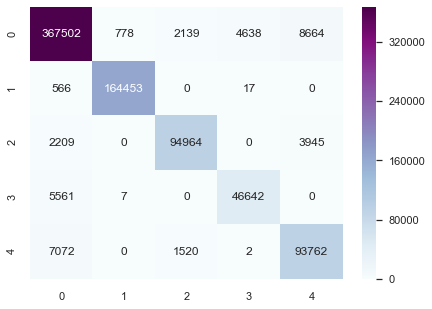

In [27]:
cm = confusion_matrix(y_test, ch_lessAcc_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.BuPu );

### Classification Prediction Error

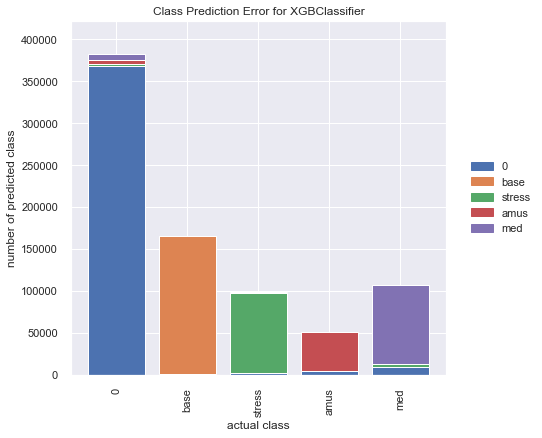

In [28]:
Classes = ['0', 'base', 'stress', 'amus', 'med']
error = ClassPredictionError(ch_lessAcc, size=(620, 450), classes=Classes)
error.score(x_test, y_test)
e = error.poof()

### Multiclass ROC AUC Score

In [29]:
def multiclass_roc_auc_score(y_test, ch_lessAcc_pred, average = 'micro'): 
    xg = preprocessing.LabelBinarizer()
    xg.fit(y_test)
    y_test1 = xg.transform(y_test) 
    y_pred1 = xg.transform(ch_lessAcc_pred)
    return roc_auc_score(y_test1, y_pred1, average=average)

aucScore = multiclass_roc_auc_score(y_test, ch_lessAcc_pred)

print('S11 All Chest less ACC')
print('-------------------------------')
print("AUC: %.2f%%" % (aucScore*100))

S11 All Chest less ACC
-------------------------------
AUC: 97.12%


##  Model ACC: Accelerometer [X,Y,Z]

### Train Test Split

In [30]:
ch_ACC = ch_loc[['cax', 'cay', 'caz', 'label']]
y = ch_ACC.label
x = ch_ACC.drop('label',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)
print(y_test.shape)

(3217760, 3)
(804441,)


### Model Fit and f1 and Balanced Accuracy Scores

In [31]:
%%time
ACC = XGBClassifier(objective = 'multi:softmax',
                    tree_method = 'gpu_hist',
                    learning_rate = 0.1,
                    gradient_based = 0.1,
                    #max_depth = 10,
                    num_early_stopping_rounds = 20,
                    n_estimators = 300,
                    gamma = 3,
                    verbosity = 2) 

model_ACC = ACC.fit(x_train, y_train)
ACC_pred = ACC.predict(x_test)
ACC_report = (classification_report(y_test,
                                    ACC_pred,
                                    labels=np.unique(ACC_pred),
                                    digits=4))

print('Balanced Accuracy:', balanced_accuracy_score(y_test, ACC_pred))
print('---------------------------------------')
print('------------ S11 Chest ACC Classification Report------------')
print(ACC_report)

Balanced Accuracy: 0.8908462560143187
---------------------------------------
------------ S11 Chest ACC Classification Report------------
              precision    recall  f1-score   support

         0.0     0.9180    0.9003    0.9091    383451
         1.0     0.9768    0.9644    0.9706    165528
         2.0     0.9221    0.9829    0.9515    101075
         3.0     0.7919    0.7727    0.7822     52013
         4.0     0.8022    0.8339    0.8177    102374

    accuracy                         0.9072    804441
   macro avg     0.8822    0.8908    0.8862    804441
weighted avg     0.9077    0.9072    0.9072    804441

Wall time: 1min 15s


### Confusion matrix 

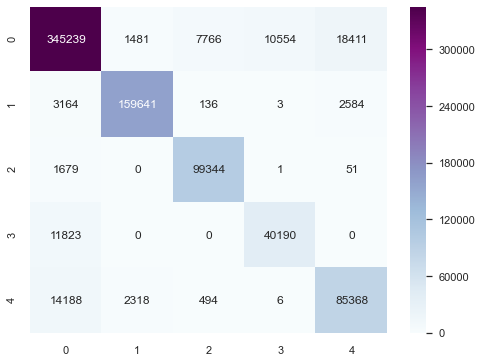

In [32]:
cm = confusion_matrix(y_test, ACC_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.BuPu );

### Classification Prediction Error

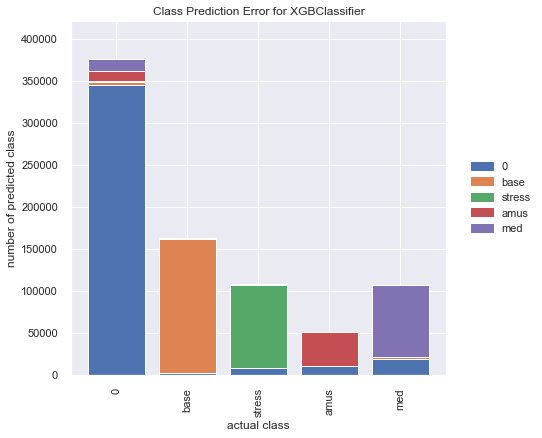

In [33]:
Classes = ['0', 'base', 'stress', 'amus', 'med']
error = ClassPredictionError(ACC, size=(620, 450), classes=Classes)
error.score(x_test, y_test)
e = error.poof()

### Multiclass ROC AUC Score

In [32]:
def multiclass_roc_auc_score(y_test, ACC_pred, average = 'macro'): #(None, 'micro', 'macro', 'weighted', 'samples')
    xg = preprocessing.LabelBinarizer()
    xg.fit(y_test)
    y_test1 = xg.transform(y_test) 
    y_pred1 = xg.transform(ACC_pred)
    return roc_auc_score(y_test1, y_pred1, average=average)

aucScore = multiclass_roc_auc_score(y_test, ACC_pred)

print('S11 Chest Accelerometer')
print('-------------------')
print("AUC: %.2f%%" % (aucScore*100))  

S11 Chest Accelerometer
-------------------
AUC: 94.94%


## Model Eda: Electrodermal Activity only

### Train Test Split

In [19]:
ch_eda= ch_loc[['ceda', 'label']]
y = ch_eda.label
x = ch_eda.drop('label',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)
print(y_test.shape)

(3217760, 1)
(804441,)


### Model Fit, classification report, and balanced accuracy 

In [20]:
%%time
Eda = XGBClassifier(objective = 'multi:softmax',
                    tree_method = 'gpu_hist',
                    learning_rate = 0.1,
                    gradient_based = 0.1,
                    num_early_stopping_rounds = 20,
                    n_estimators = 300,
                    #max_depth = 10,
                    gamma = 3,
                    Eseed = 24,
                    verbosity = 2) 

model_Eda = Eda.fit(x_train, y_train)
Eda_pred = Eda.predict(x_test)
Eda_report = (classification_report(y_test,
                                    Eda_pred,
                                    labels = np.unique(Eda_pred),
                                    digits = 4))

print('Balanced Accuracy:', balanced_accuracy_score(y_test, Eda_pred))
print('---------------------------------------')
print('------------ S11 Chest Electrodermal Activity Classification Report------------')
print(Eda_report)

Balanced Accuracy: 0.774356045293555
---------------------------------------
------------ S11 Chest Electrodermal Activity Classification Report------------
              precision    recall  f1-score   support

         0.0     0.8093    0.8137    0.8115    384126
         1.0     0.9601    0.9560    0.9580    165305
         2.0     0.6661    0.7097    0.6872    100669
         3.0     0.8891    0.7600    0.8195     51751
         4.0     0.6353    0.6323    0.6338    102590

    accuracy                         0.8034    804441
   macro avg     0.7920    0.7744    0.7820    804441
weighted avg     0.8053    0.8034    0.8039    804441

Wall time: 1min 5s


### Confusion Matrix

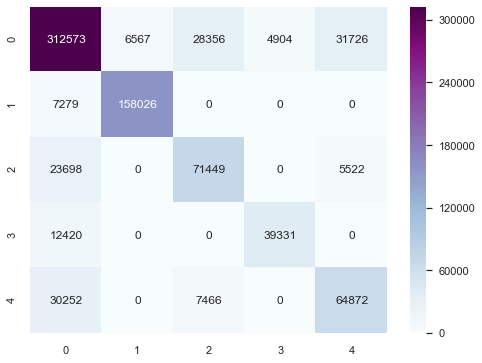

In [21]:
cm = confusion_matrix(y_test, Eda_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.BuPu );

### Classification Prediction Error

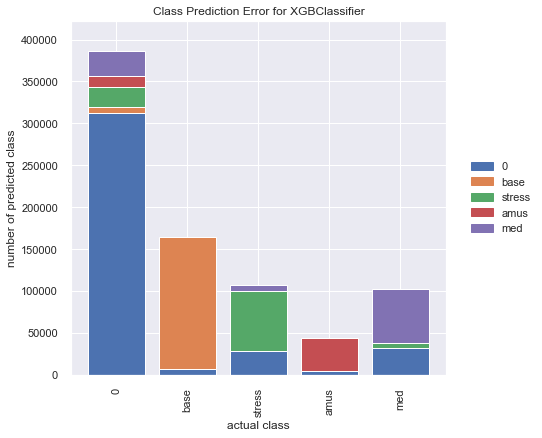

In [22]:
Classes = ['0', 'base', 'stress', 'amus', 'med']
error = ClassPredictionError(Eda, size=(620, 450), classes=Classes)
error.score(x_test, y_test)
e = error.poof()

### Multiclass ROC AUC Score

In [23]:
def multiclass_roc_auc_score(y_test, Eda_pred, average = 'macro'): #(None, 'micro', 'macro', 'weighted', 'samples')
    xg = preprocessing.LabelBinarizer()
    xg.fit(y_test)
    y_test1 = xg.transform(y_test) 
    y_pred1 = xg.transform(Eda_pred)
    return roc_auc_score(y_test1, y_pred1, average=average)

aucScore = multiclass_roc_auc_score(y_test, Eda_pred)

print('S11 Chest Skin Temperature')
print('-------------------')
print("AUC: %.2f%%" % (aucScore*100))  

S11 Chest Skin Temperature
-------------------
AUC: 85.76%


### Model ACC TEMP EDA

In [20]:
less_Emg_Ecg = ch_loc[['ceda', 'ctemp', 'cax', 'cay', 'caz', 'label']]
y = less_Emg_Ecg.label
x = less_Emg_Ecg.drop('label',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)
print(y_test.shape)

(3217760, 5)
(804441,)


#### Model Fit, classification report, and Balanced Accuracy 

In [21]:
%%time
accEdaTemp = XGBClassifier(objective = 'multi:softmax',
                           tree_method = 'gpu_hist',
                           learning_rate = 0.1,
                           gradient_based = 0.1,
                           num_early_stopping_rounds = 20,
                           n_estimators = 300,
                           gamma = 3,
                           verbosity = 2) 

model_accEdaTemp = accEdaTemp.fit(x_train, y_train)
accEdaTemp_pred = accEdaTemp.predict(x_test)
accEdaTemp_report = (classification_report(y_test, 
                                         accEdaTemp_pred, 
                                         labels = np.unique(accEdaTemp_pred),
                                         digits = 4))

print('Balanced Accuracy:', balanced_accuracy_score(y_test, accEdaTemp_pred))
print('---------------------------------------')
print('------------ S17 ACC EDA TEMP Classification Report------------')
print(accEdaTemp_report)

Balanced Accuracy: 0.9904657170296376
---------------------------------------
------------ S17 ACC EDA TEMP Classification Report------------
              precision    recall  f1-score   support

         0.0     0.9932    0.9854    0.9893    383940
         1.0     0.9973    0.9987    0.9980    165410
         2.0     0.9976    0.9979    0.9978    101044
         3.0     0.9580    0.9828    0.9703     51873
         4.0     0.9741    0.9874    0.9807    102174

    accuracy                         0.9898    804441
   macro avg     0.9841    0.9905    0.9872    804441
weighted avg     0.9899    0.9898    0.9898    804441

Wall time: 1min 18s


#### Confusion matrix

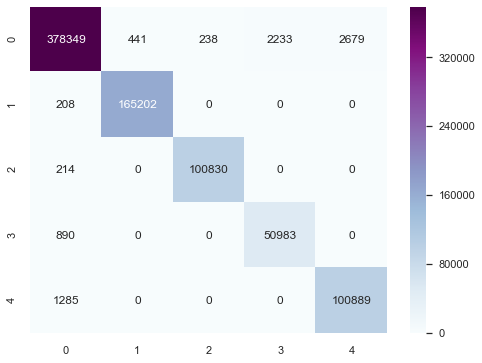

In [22]:
cm = confusion_matrix(y_test, accEdaTemp_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.BuPu );

#### Classification Prediction Error

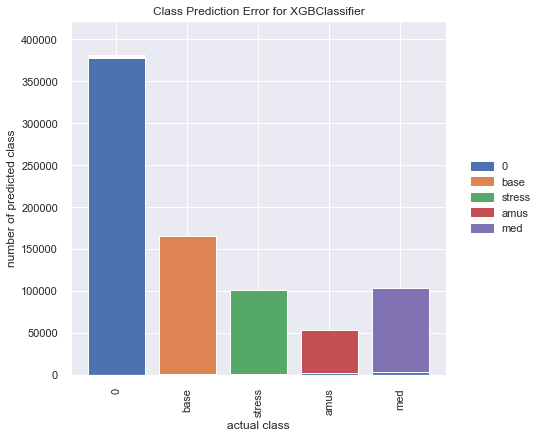

In [23]:
sns.set(style="darkgrid")
Classes = ['0', 'base', 'stress', 'amus', 'med']
error = ClassPredictionError(accEdaTemp, size=(620, 450), classes=Classes)
error.score(x_test, y_test)
e = error.poof()

#### Multiclass ROC AUC Score

In [24]:
def multiclass_roc_auc_score(y_test, accEdaTemp_pred, average = 'macro'): #(None, 'micro', 'macro', 'weighted', 'samples')
    xg = preprocessing.LabelBinarizer()
    xg.fit(y_test)
    y_test1 = xg.transform(y_test) 
    y_pred1 = xg.transform(accEdaTemp_pred)
    return roc_auc_score(y_test1, y_pred1, average=average)

aucScore = multiclass_roc_auc_score(y_test, accEdaTemp_pred)

print('S17 ACC EDA TEMP')
print('-------------------')
print("AUC: %.2f%%" % (aucScore*100))

S17 ACC EDA TEMP
-------------------
AUC: 99.38%
